In [1]:
# Libraries

import json
import numpy
import os
import platform
import shutil
import sys

In [2]:
# Root directory

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.cnn.models import Zrimec2020c

from source.python.cnn import core     as cnn_core
from source.python.cnn import dataset  as cnn_dataset
from source.python.cnn import model    as cnn_model
from source.python.cnn import mutation as cnn_mutation
from source.python.cnn import plot     as cnn_plot
from source.python.cnn import util     as cnn_util
from source.python.io  import loader   as data_loader

# 1. Setup

In [4]:
# Setup some directory paths.

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      'nbp07-zrimec2020', 'classification')
OUT_MODEL = os.path.join(OUT_DATA, 'model')
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_NBP04 = os.path.join(OUT,      'nbp04-feature')
RES_NBP05 = os.path.join(OUT,      'nbp05-target')

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA,  exist_ok = True)
os.makedirs(OUT_MODEL, exist_ok = True)
os.makedirs(OUT_PLOT,  exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_MODEL}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_NBP04}')
print(f' Resource Directory : {RES_NBP05}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp07-zrimec2020\classification
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp07-zrimec2020\classification\model
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp07-zrimec2020\classification\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp04-feature
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp05-target


In [5]:
# System and device

DEVICE = cnn_core.get_device(only_cpu = False)
SYSTEM = cnn_core.get_system_info()

for key, value in SYSTEM.items() :
	print('{:16s} : {}'.format(key, value))

platform_python  : 3.10.7
platform_system  : Windows
platform_release : 10
platform_version : 10.0.19044
cpu_name         : N/A
cpu_count        : 12
cuda_name        : NVIDIA GeForce RTX 3060 Ti
cuda_available   : True
cuda_devices     : 1
memory_total     : 31.924 GB
memory_available : 16.289 GB


In [6]:
# Load the input transcript features

mutation_gene_sequences = data_loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'mutation-features-bp2150.fasta'),
	to_string = True
)

mutation_gene_frequency = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'mutation-features-frequency.npz')
)

mutation_gene_stability = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'mutation-features-stability.npz')
)

gene_sequences = data_loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'features-bp2150.fasta'),
	to_string = True
)

gene_frequency = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-frequency.npz')
)

gene_stability = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-stability.npz')
)

tpm_label = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-labels.json'),
	to_numpy = True
)

tpm_order = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-order.json')
)

# 2. Config

In [7]:
# Define basic data parameters

config = {
	'random_seed' : None,
	'batch_size' : {
		'train' : 64,
		'valid' : 64,
		'test'  : 64
	},
	'split_size' : {
		'valid' : 0.2,
		'test'  : 0.2
	},
	'input' : {
		'channels' : 1,
		'height'   : 4,
		'width'    : 2150,
		'features' : 64
	},
	'output' : {
		'group0'  : 'tissue',
		'group1'  : 'tissue-mean',
		'length'  : 8,
		'classes' : 5
	}
}

# Ensure correct
config['output']['length'] = len(tpm_order[config['output']['group0']])
config['output']['classes'] = len(numpy.unique([value[config['output']['group1']] for value in tpm_label.values()]))

In [8]:
# Get the correct output group

gene_targets = {
	key : numpy.array(value[config['output']['group1']], dtype = numpy.int64)
	for key, value in tpm_label.items()
}

In [9]:
# Get the correct output order

tpm_order = tpm_order[config['output']['group0']]

In [10]:
# Lock random

config['random_seed'] = cnn_core.lock_random(
	seed = config['random_seed'],
	generate_seed = True
)

print('Random seed : {}'.format(config['random_seed']))

Random seed : 733694691


# 3. Dataloaders

## 3.1 Normal

In [11]:
# Create dataloader

dataset = cnn_dataset.to_dataset(
	sequences   = gene_sequences,
	features    = gene_frequency,
	targets     = gene_targets,
	expand_dims = None
)

dataloaders = cnn_dataset.to_dataloaders(
	dataset     = dataset,
	split_size  = config['split_size'],
	batch_size  = config['batch_size'],
	random_seed = config['random_seed']
)

train_dataloader = dataloaders[0]
valid_dataloader = dataloaders[1]
test_dataloader  = dataloaders[2]

In [12]:
# Display train dataloader

cnn_dataset.show_dataloader(
	dataloader = train_dataloader,
	batch_size = config['batch_size']['train']
)

Dataloader  batch  size :     64
Dataloader  batch count :    304
Dataloader sample count : 19,456

     Key shape : (64,)
Sequence shape : torch.Size([64, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 5])


In [13]:
# Display valid dataloader

cnn_dataset.show_dataloader(
	dataloader = valid_dataloader,
	batch_size = config['batch_size']['valid']
)

Dataloader  batch  size :     64
Dataloader  batch count :     76
Dataloader sample count :  4,864

     Key shape : (64,)
Sequence shape : torch.Size([64, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 5])


In [14]:
# Display test dataloader

cnn_dataset.show_dataloader(
	dataloader = test_dataloader,
	batch_size = config['batch_size']['test']
)

Dataloader  batch  size :     64
Dataloader  batch count :     95
Dataloader sample count :  6,080

     Key shape : (64,)
Sequence shape : torch.Size([64, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 5])


## 3.2 Mutation

In [15]:
# Create mutation dataloader

mutation_dataloader = cnn_mutation.create_dataloader(
	sequences   = mutation_gene_sequences,
	features    = mutation_gene_frequency,
	targets     = gene_targets,
	expand_dims = None,
	random_seed = config['random_seed']
)

In [16]:
# Display mutation dataloader

cnn_dataset.show_dataloader(
	dataloader = mutation_dataloader,
	batch_size = 1
)

Dataloader  batch  size :      1
Dataloader  batch count :  2,525
Dataloader sample count :  2,525

     Key shape : (1,)
Sequence shape : torch.Size([1, 4, 2150])
 Feature shape : torch.Size([1, 64])
  Target shape : torch.Size([1, 5])


# 4. Model

## 4.1 Structure

In [17]:
# Create and display the model structure

model = Zrimec2020c(params = {
	'other' : {
		'in_height'   : config['input']['height'],
		'in_width'    : config['input']['width'],
		'in_features' : config['input']['features'],
		'dropout'     : 0.1
	},
	'conv1' : {
		'filters' : 64,
		'kernel'  : 21,
		'padding' : 'none'
	},
	'conv2' : {
		'filters' : 64,
		'kernel'  : 31,
		'padding' : 'none'
	},
	'conv3' : {
		'filters' : 128,
		'kernel'  : 5,
		'padding' : 'same'
	},
	'maxpool1' : {
		'kernel'  : 9,
		'padding' : 'same'
	},
	'maxpool2' : {
		'kernel'  : 3,
		'padding' : 'same'
	},
	'maxpool3' : {
		'kernel'  : 3,
		'padding' : 'same'
	},
	'fc1' : {
		'features' : 128
	},
	'fc2' : {
		'features' : 256
	},
	'fc3' : {
		'features' : config['output']['classes'],
		'heads'    : config['output']['length']
	}
})

model.summary(
	batch_size  = config['batch_size']['train'],
	in_height   = config['input']['height'],
	in_width    = config['input']['width'],
	in_features = config['input']['features'],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Zrimec2020c                              [64, 4, 2150]             [64, 5, 5]                --
├─Zrimec2020: 1-1                        [64, 4, 2150]             [64, 256]                 --
│    └─Conv1d: 2-1                       [64, 4, 2150]             [64, 64, 2130]            5,440
│    └─ReLU: 2-2                         [64, 64, 2130]            [64, 64, 2130]            --
│    └─BatchNorm1d: 2-3                  [64, 64, 2130]            [64, 64, 2130]            128
│    └─Dropout: 2-4                      [64, 64, 2130]            [64, 64, 2130]            --
│    └─MaxPool1d: 2-5                    [64, 64, 2130]            [64, 64, 426]             --
│    └─Conv1d: 2-6                       [64, 64, 426]             [64, 64, 396]             127,040
│    └─ReLU: 2-7                         [64, 64, 396]             [64, 64, 396]             --
│    └─BatchNorm1d: 2-8   

In [18]:
# Convert the model to double and initialize weights and biases

model = model.double()
model = model.apply(cnn_model.he_uniform_weight)
model = model.apply(cnn_model.zero_bias)

## 4.2 Parameters

In [19]:
# Set the training parameters

criterion = cnn_model.get_criterion(
	query     = 'entropy',
	reduction = 'mean',
	weights   = None
)

optimizer = cnn_model.get_optimizer(
	query        = 'adam',
	model        = model,
	lr           = 0.001,
	betas        = (0.900, 0.999),
	weight_decay = 0.05
)

scheduler = cnn_model.get_scheduler(
	query     = 'plateau',
	mode      = 'min',
	optimizer = optimizer,
	patience  = 5,
	factor    = 0.5,
	min_lr    = 1e-8
)

params = {
	'model'     : model,
	'savebest'  : os.path.join(OUT_MODEL, f'{model.__name__}-best.pth'),
	'savelast'  : os.path.join(OUT_MODEL, f'{model.__name__}-last.pth'),
	'epochs'    : 25,
	'criterion' : criterion,
	'optimizer' : optimizer,
	'scheduler' : scheduler,
	'device'    : DEVICE,
	'verbose'   : False,
	'train_dataloader' : train_dataloader,
	'valid_dataloader' : valid_dataloader,
	'test_dataloader'  : test_dataloader,
	'metrics' : {
		'entropy'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'entropy'),
		'accuracy' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'accuracy')
	}
}

## 4.3 Training

In [20]:
# Train and validate the model

report = cnn_model.train_classifier(
	model  = model,
	params = params
)

## 4.4 Visualization

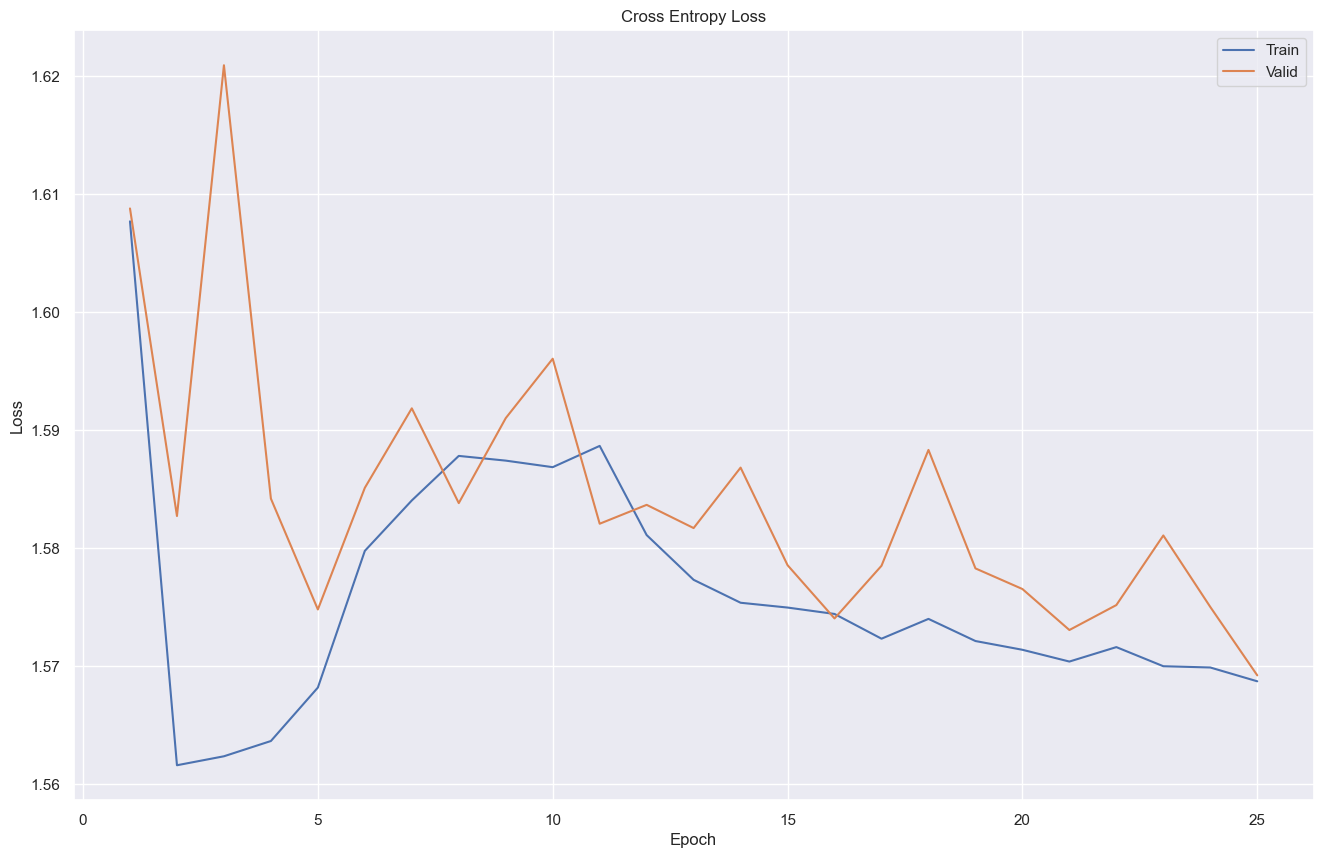

In [21]:
# Display the training and validation loss curves

cnn_plot.show_loss(
	report   = report,
	title    = 'Cross Entropy Loss',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

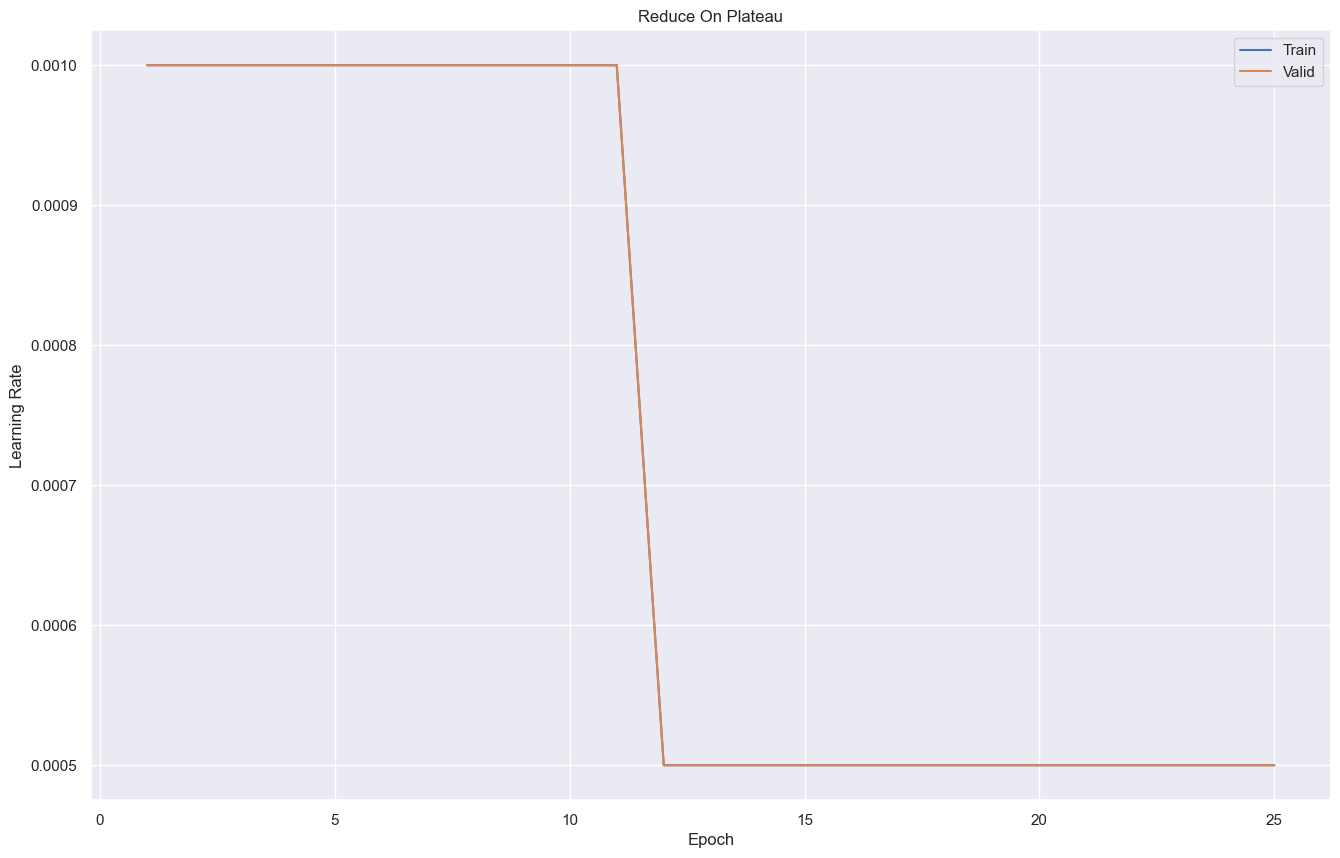

In [22]:
# Display the training and validation learning rate curves

cnn_plot.show_lr(
	report   = report,
	title    = 'Reduce On Plateau',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

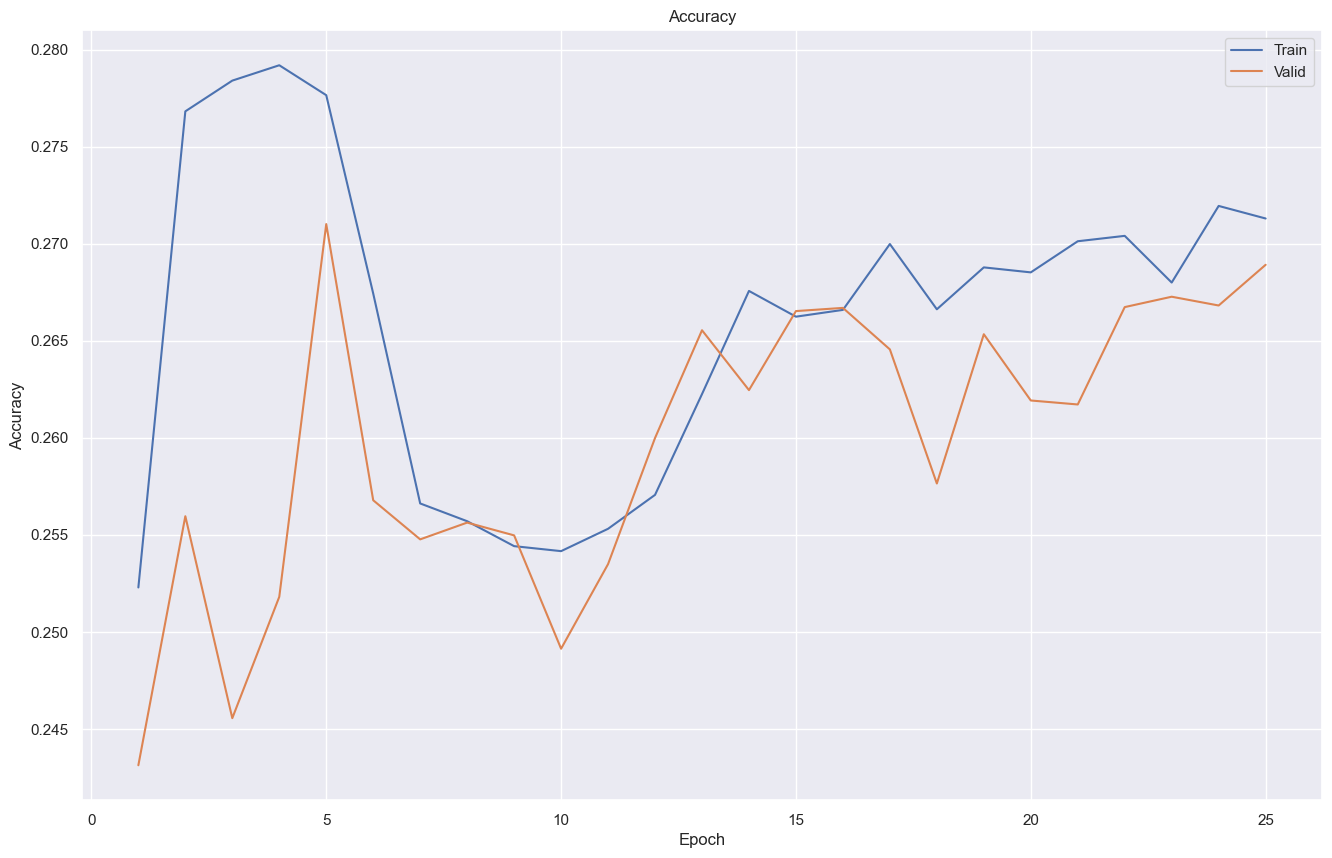

In [23]:
# Display the training and validation accuracy curves

cnn_plot.show_accuracy(
	report   = report,
	title    = 'Accuracy',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

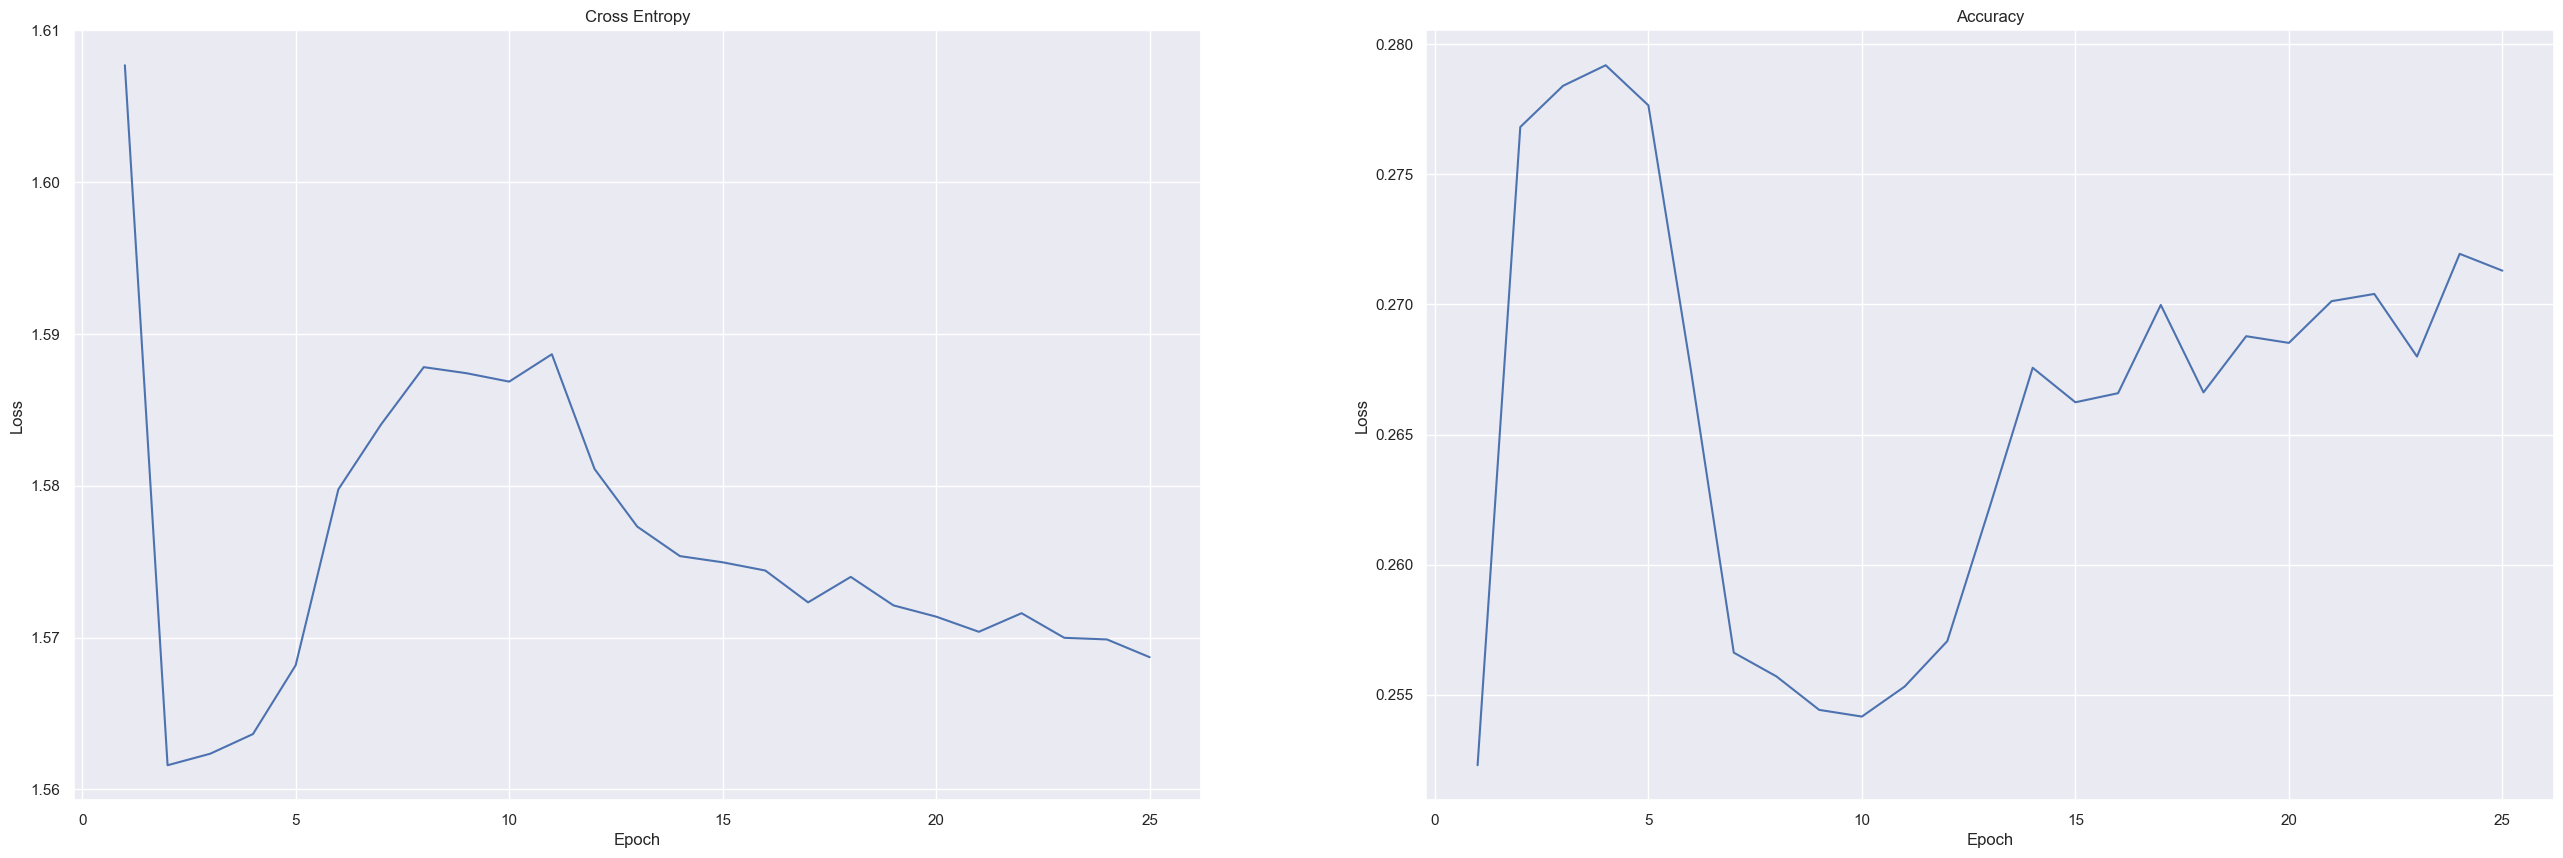

In [24]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'train',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-train')
)

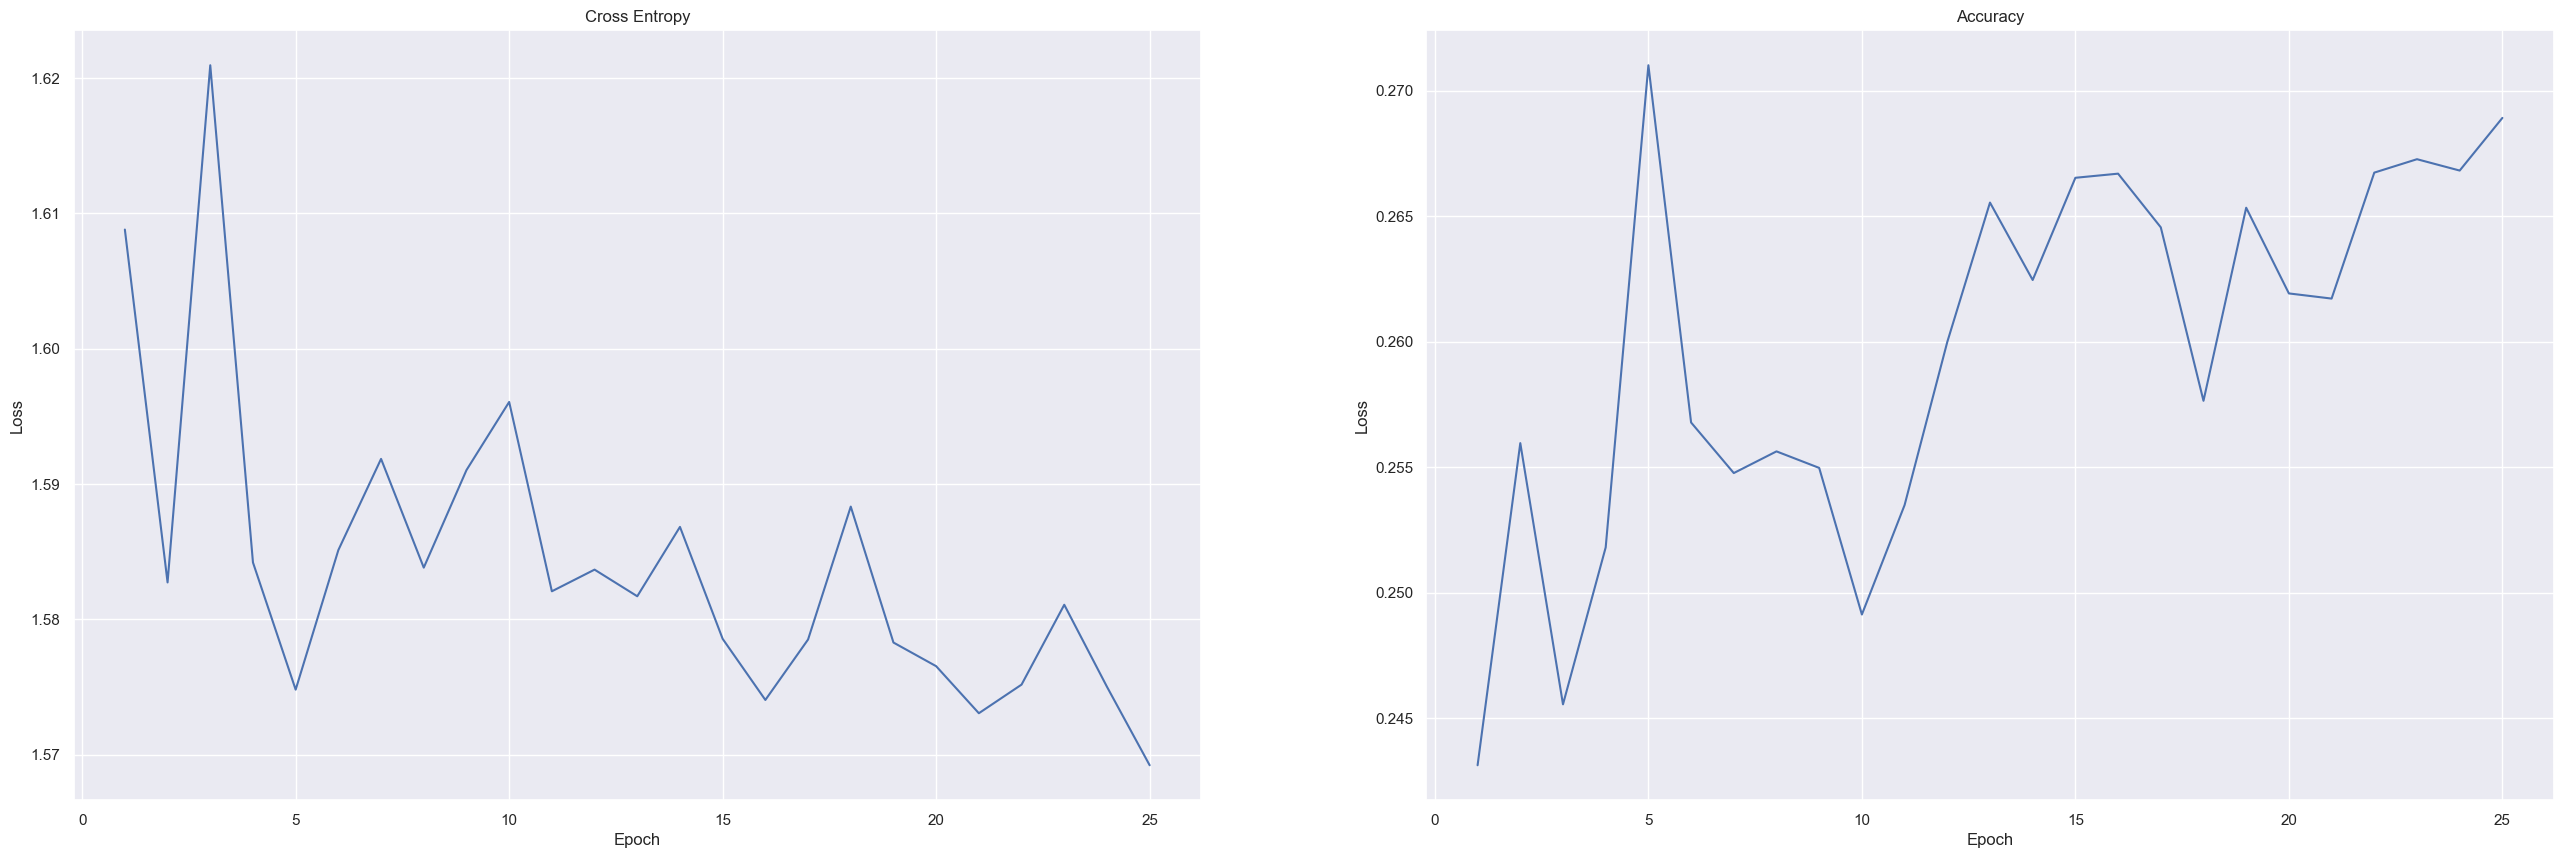

In [25]:
# Display the validation metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'valid',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-valid')
)

# 5. Evaluation

## 5.1 Last Model

### 5.1.1 Evaluation

In [26]:
# Load last model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-last.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print('Loss  : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 25
Loss  : 1.56921


<All keys matched successfully>

In [27]:
# Evaluate the full model

report = cnn_model.eval_classifier(
	model  = model,
	params = params
)

print('Accuracy : ' + '{: 8.5f}'.format(report['eval']['metric']['accuracy'].mean()))
print('Entropy  : ' + '{: 8.5f}'.format(report['eval']['metric']['entropy'].mean()))

Accuracy :  0.26891
Entropy  :  1.57285


### 5.1.2 Custom

In [28]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_classification_predictions(report = report, n = 2)

Gene     : AT4G29800.2
True     : [0 0 2 1 1]
Pred     : [4 0 2 0 2]
Entropy  : [1.73766   1.44445   1.59195   1.56059   1.58585]
Accuracy : [0.00000   1.00000   1.00000   0.00000   0.00000]

Gene     : AT3G26280.1
True     : [1 3 0 1 3]
Pred     : [4 0 2 0 2]
Entropy  : [1.61555   1.65677   1.63296   1.56060   1.60830]
Accuracy : [0.00000   0.00000   0.00000   0.00000   0.00000]



In [29]:
# Display the evaluation accuracy

dataframe = cnn_util.display_classification_accuracy(
	report = report,
	order  = tpm_order
).sort_values('Accuracy', ascending = False)

print('Average Accuracy : {:8.5f} %'.format(dataframe['Accuracy'].mean()))
print('Average Missed 1 : {:8.5f} %'.format(dataframe['Missed_1'].mean()))
print('Average Missed 2 : {:8.5f} %'.format(dataframe['Missed_2'].mean()))
print('Average Missed 3 : {:8.5f} %'.format(dataframe['Missed_3'].mean()))
print('Average Missed 4 : {:8.5f} %'.format(dataframe['Missed_4'].mean()))
print()

dataframe

Average Accuracy : 26.89145 %
Average Missed 1 : 28.07566 %
Average Missed 2 : 23.83882 %
Average Missed 3 : 12.82566 %
Average Missed 4 :  8.36842 %



,Group,Total,Accuracy,Missed_1,Missed_2,Missed_3,Missed_4
1,leaf,6080,29.786,22.632,19.260,16.447,11.875
0,flower,6080,27.484,22.007,19.720,18.355,12.434
3,seed,6080,27.385,27.615,20.526,15.740,8.734
2,root,6080,26.020,33.043,28.865,7.220,4.852
4,seedling,6080,23.783,35.082,30.822,6.365,3.947


### 5.1.3 Visualization

### 5.1.4 Mutation

In [30]:
# Evaluate the mutations

report = cnn_model.eval_classifier(
	model  = model,
	params = params | {
		'test_dataloader' : mutation_dataloader,
		'metrics' : {
			'entropy'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'entropy'),
			'accuracy' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'accuracy')
		}
	}
)

print('Accuracy : ' + '{: 8.5f}'.format(report['eval']['metric']['accuracy'].mean()))
print('Entropy  : ' + '{: 8.5f}'.format(report['eval']['metric']['entropy'].mean()))

Accuracy :  0.26962
Entropy  :  1.56625


In [31]:
# Transform model report to mutation report

mutation_report = cnn_mutation.get_mutation_report(report = report)

transcript = list(mutation_report.keys())[0]
mutation   = list(mutation_report[transcript].keys())[0]

print('Transcripts : {}'.format(len(mutation_report)))
print('Mutations   : {}'.format(len(mutation_report[transcript])))
print('Variants    : {}'.format(len(mutation_report[transcript][mutation]['label'])))

Transcripts : 25
Mutations   : 6
Variants    : 20


In [32]:
# Print mutations

print(' ' + ' '.join(x if i % 10 != 0 else x + '\n' for i, x in enumerate(mutation_report.keys(), start = 1)))

 AT4G18040.1 AT3G48040.1 AT1G10030.1 AT3G29020.2 AT1G07900.1 AT2G01590.2 AT2G18780.1 AT2G31320.1 AT3G56230.1 AT5G26980.2
 AT1G29290.1 AT4G19610.1 AT5G25160.1 AT3G24630.1 AT3G49900.2 AT1G78160.2 AT4G08850.1 AT1G72240.1 AT4G36870.2 AT5G25800.2
 AT5G56490.1 AT5G22780.1 AT1G09060.1 AT5G19510.1 AT1G04360.1


In [33]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_classification(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M01',
	order      = tpm_order
)

TODO - to be implemented


In [34]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_classification(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M05',
	order      = tpm_order
)

TODO - to be implemented


In [35]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_classification(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M10',
	order      = tpm_order
)

TODO - to be implemented


## 5.2 Best Model

### 5.2.1 Evaluation

In [36]:
# Load best model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-best.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print(' Loss : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 25
 Loss : 1.56921


<All keys matched successfully>

In [37]:
# Evaluate the full model

report = cnn_model.eval_classifier(
	model  = model,
	params = params
)

print('Accuracy : ' + '{: 8.5f}'.format(report['eval']['metric']['accuracy'].mean()))
print('Entropy  : ' + '{: 8.5f}'.format(report['eval']['metric']['entropy'].mean()))

Accuracy :  0.26901
Entropy  :  1.57279


### 5.2.2 Custom

In [38]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_classification_predictions(report = report, n = 2)

Gene     : AT1G44446.3
True     : [2 3 0 2 2]
Pred     : [4 0 2 0 2]
Entropy  : [1.58986   1.65564   1.63522   1.59764   1.58522]
Accuracy : [0.00000   0.00000   0.00000   0.00000   1.00000]

Gene     : AT1G30530.1
True     : [4 4 2 4 4]
Pred     : [4 0 2 0 2]
Entropy  : [1.55093   1.74936   1.59195   1.72507   1.67438]
Accuracy : [1.00000   0.00000   1.00000   0.00000   0.00000]



In [39]:
# Display the evaluation accuracy

dataframe = cnn_util.display_classification_accuracy(
	report = report,
	order  = tpm_order
).sort_values('Accuracy', ascending = False)

print('Average Accuracy : {:8.5f} %'.format(dataframe['Accuracy'].mean()))
print('Average Missed 1 : {:8.5f} %'.format(dataframe['Missed_1'].mean()))
print('Average Missed 2 : {:8.5f} %'.format(dataframe['Missed_2'].mean()))
print('Average Missed 3 : {:8.5f} %'.format(dataframe['Missed_3'].mean()))
print('Average Missed 4 : {:8.5f} %'.format(dataframe['Missed_4'].mean()))
print()

dataframe

Average Accuracy : 26.90132 %
Average Missed 1 : 28.07566 %
Average Missed 2 : 23.84211 %
Average Missed 3 : 12.82566 %
Average Missed 4 :  8.35526 %



,Group,Total,Accuracy,Missed_1,Missed_2,Missed_3,Missed_4
1,leaf,6080,29.786,22.615,19.276,16.447,11.875
0,flower,6080,27.500,22.007,19.720,18.355,12.418
3,seed,6080,27.401,27.615,20.526,15.740,8.717
2,root,6080,26.036,33.043,28.865,7.220,4.836
4,seedling,6080,23.783,35.099,30.822,6.365,3.931


### 5.2.3 Visualization

### 5.2.4 Mutation

In [40]:
# Evaluate the mutations

report = cnn_model.eval_classifier(
	model  = model,
	params = params | {
		'test_dataloader' : mutation_dataloader,
		'metrics' : {
			'entropy'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'entropy'),
			'accuracy' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'accuracy')
		}
	}
)

print('Accuracy : ' + '{: 8.5f}'.format(report['eval']['metric']['accuracy'].mean()))
print('Entropy  : ' + '{: 8.5f}'.format(report['eval']['metric']['entropy'].mean()))

Accuracy :  0.26962
Entropy  :  1.56625


In [41]:
# Transform model report to mutation report

mutation_report = cnn_mutation.get_mutation_report(report = report)

transcript = list(mutation_report.keys())[0]
mutation   = list(mutation_report[transcript].keys())[0]

print('Transcripts : {}'.format(len(mutation_report)))
print('Mutations   : {}'.format(len(mutation_report[transcript])))
print('Variants    : {}'.format(len(mutation_report[transcript][mutation]['label'])))

Transcripts : 25
Mutations   : 6
Variants    : 20


In [42]:
# Print mutations

print(' ' + ' '.join(x if i % 10 != 0 else x + '\n' for i, x in enumerate(mutation_report.keys(), start = 1)))

 AT3G48040.1 AT4G08850.1 AT3G24630.1 AT3G56230.1 AT3G29020.2 AT5G25800.2 AT2G01590.2 AT4G19610.1 AT5G26980.2 AT4G18040.1
 AT1G29290.1 AT5G19510.1 AT1G04360.1 AT2G18780.1 AT1G72240.1 AT1G09060.1 AT5G22780.1 AT5G25160.1 AT4G36870.2 AT1G78160.2
 AT3G49900.2 AT1G10030.1 AT1G07900.1 AT5G56490.1 AT2G31320.1


In [43]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_classification(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M01',
	order      = tpm_order
)

TODO - to be implemented


In [44]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_classification(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M05',
	order      = tpm_order
)

TODO - to be implemented


In [45]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_classification(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M10',
	order      = tpm_order
)

TODO - to be implemented
